# Alzheimer's Prediction using MMSE Features

In [1]:
# Core Libraries
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Logistic Regression tools
from Logistic_bootstrap_metrics import bootstrap_metrics, plot_roc_curve, build_summary_table

# Machine Learning Tools
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (
    roc_auc_score,
    balanced_accuracy_score,
    accuracy_score,
    f1_score,
    recall_score,
    confusion_matrix,
    roc_curve,
    auc,
    classification_report
)

# Other Models (for later if you use them)
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Resampling
from imblearn.over_sampling import SMOTE


## Load and Prepare Data

In [ ]:
# Load dataset
df = pd.read_csv("data/Filtered_Data.csv")

# Split into train and test based on 'Split' column
df_train = df[df['Split'] == 'Train']
df_test = df[df['Split'] == 'Test']

# Define MMSE question columns
mmse_cols = [
    # A. Orientation
    "MMYEAR", "MMMONTH", "MMDAY", "MMSEASON", "MMDATE",
    "MMSTATE", "MMCITY", "MMAREA", "MMHOSPIT", "MMFLOOR",

    # B. Registration
    "WORD1", "WORD2", "WORD3",

    # C. Attention and Calculation – Serial 7s only
    "MMD", "MML", "MMR", "MMO", "MMW",
    
    # C. Attention and Calculation – "WORLD" Backward Spelling
    "MMLTR1", "MMLTR2", "MMLTR3", "MMLTR4", "MMLTR5",
    "MMLTR6", "MMLTR7",

    # D. Recall
    "WORD1DL", "WORD2DL", "WORD3DL",

    # E. Language
    "MMWATCH", "MMPENCIL", "MMREPEAT",
    "MMHAND", "MMFOLD", "MMONFLR",
    "MMREAD", "MMWRITE", "MMDRAW"
]

# Define MMSE question categories
categories = {
    "Orientation_Time": ["MMYEAR", "MMMONTH", "MMDAY", "MMSEASON", "MMDATE"],
    "Orientation_Place": ["MMSTATE", "MMCITY", "MMAREA", "MMHOSPIT", "MMFLOOR"],
    "Registration": ["WORD1", "WORD2", "WORD3"],
    "Attention_Calculation": ["MMD", "MML", "MMR", "MMO", "MMW", "MMLTR1", "MMLTR2", "MMLTR3", "MMLTR4", "MMLTR5", "MMLTR6", "MMLTR7"],
    "Recall": ["WORD1DL", "WORD2DL", "WORD3DL"],
    "Language": ["MMWATCH", "MMPENCIL", "MMREPEAT", "MMHAND", "MMFOLD", "MMONFLR", "MMREAD", "MMWRITE", "MMDRAW"]
}

# Updated categories (only good questions kept!)
updated_categories = {
    "Orientation_Time": ["MMYEAR", "MMMONTH", "MMDAY", "MMSEASON", "MMDATE"],
    "Orientation_Place": ["MMSTATE", "MMCITY", "MMAREA", "MMHOSPIT", "MMFLOOR"],
    "Attention_Calculation": ["MMD", "MML", "MMR", "MMO", "MMW"],
    "Recall": ["WORD1DL", "WORD2DL", "WORD3DL"],
    "Language": ["MMWATCH", "MMPENCIL"]
}

# ClinicalBERT embeddings
df_clincalbert_train = pd.read_csv("data/Embeddings/ClinicalBERT_Train.csv")
df_clincalbert_test = pd.read_csv("data/Embeddings/ClinicalBERT_Test.csv")
df_context_clinicalbert_test = pd.read_csv("data/Embeddings/Context_ClinicalBERT_Train.csv")
df_context_clinicalbert_train = pd.read_csv("data/Embeddings/Context_ClinicalBERT_Test.csv")

# BioBERT embeddings
df_biobert_train = pd.read_csv("data/Embeddings/BioBERT_Train.csv")
df_biobert_test = pd.read_csv("data/Embeddings/BioBERT_Test.csv")
df_context_biobert_test = pd.read_csv("data/Embeddings/Context_BioBERT_Train.csv")
df_context_biobert_train = pd.read_csv("data/Embeddings/Context_BioBERT_Test.csv")

# MedBERT embeddings
df_medbert_train = pd.read_csv("data/Embeddings/MedBERT_Train.csv")
df_medbert_test = pd.read_csv("data/Embeddings/MedBERT_Test.csv")
df_context_medbert_test = pd.read_csv("data/Embeddings/Context_MedBERT_Train.csv")
df_context_medbert_train = pd.read_csv("data/Embeddings/Context_MedBERT_Test.csv")


## Helper Functions

In [3]:
def prepare_features_for_logistic_regression(X_train, X_test, variance_threshold=1e-5, correlation_threshold=0.98):
    from sklearn.feature_selection import VarianceThreshold
    import numpy as np
    import pandas as pd

    selector = VarianceThreshold(threshold=variance_threshold)
    X_train_reduced = selector.fit_transform(X_train)
    X_test_reduced = selector.transform(X_test)

    kept_features = X_train.columns[selector.get_support()]
    X_train_reduced = pd.DataFrame(X_train_reduced, columns=kept_features, index=X_train.index)
    X_test_reduced = pd.DataFrame(X_test_reduced, columns=kept_features, index=X_test.index)

    corr_matrix = X_train_reduced.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper.columns if any(upper[column] > correlation_threshold)]

    X_train_final = X_train_reduced.drop(columns=to_drop)
    X_test_final = X_test_reduced.drop(columns=to_drop)

    return X_train_final, X_test_final

def run_logistic_regression_pipeline(train_df, test_df, embedding_cols, categories, model_name="ClinicalBERT", target_var='AD', n_bootstrap=1000):
    from Logistic_bootstrap_metrics import bootstrap_metrics, plot_roc_curve
    import pandas as pd

    # --- Per category logistic regression ---
    category_results = []
    for category_name, mmse_codes in categories.items():
        print(f"\nRunning logistic regression for {model_name} - Category: {category_name}")

        train_filtered = train_df[train_df['MMSE Code'].isin(mmse_codes)]
        test_filtered = test_df[test_df['MMSE Code'].isin(mmse_codes)]

        if len(train_filtered) < 10 or len(test_filtered) < 10:
            print(f"Skipping {category_name} (not enough samples)")
            continue

        X_train = train_filtered[embedding_cols]
        y_train = train_filtered[target_var]
        X_test = test_filtered[embedding_cols]
        y_test = test_filtered[target_var]

        result = bootstrap_metrics(
            df_train=X_train,
            df_test=X_test,
            independent_vars=embedding_cols,
            dep_var_train=y_train,
            dep_var_test=y_test,
            n_bootstrap=n_bootstrap
        )

        category_results.append({
            'Category': category_name,
            'Best Threshold': result["Best Threshold"],
            'Odds Ratios': result["Odds Ratios (one-time fit)"],
            'Bootstrapped Metrics': result["Bootstrapped Metrics"],
            'True Labels': result["True Labels"],
            'Predicted Probabilities': result["Predicted Probabilities"]
        })

    # --- Combined model: mean embeddings per category ---
    print(f"\nRunning combined logistic regression for {model_name} (mean embeddings per category)")

    def compute_category_means(df, embedding_cols, mmse_codes_dict):
        category_mean_features = pd.DataFrame(index=df['subject_id'].unique())
        for category, codes in mmse_codes_dict.items():
            filtered = df[df['MMSE Code'].isin(codes)]
            if not filtered.empty:
                mean_embeddings = filtered.groupby('subject_id')[embedding_cols].mean()
                mean_embeddings = mean_embeddings.add_prefix(f"{category}_")
                category_mean_features = category_mean_features.join(mean_embeddings, how='left')
        return category_mean_features

    train_df['subject_id'] = train_df['subject_id'].astype(str)
    test_df['subject_id'] = test_df['subject_id'].astype(str)

    train_means = compute_category_means(train_df, embedding_cols, categories)
    test_means = compute_category_means(test_df, embedding_cols, categories)

    train_labels = train_df[['subject_id', target_var]].drop_duplicates().set_index('subject_id')
    test_labels = test_df[['subject_id', target_var]].drop_duplicates().set_index('subject_id')

    train_means = train_means.join(train_labels).dropna()
    test_means = test_means.join(test_labels).dropna()

    X_train_combined = train_means.drop(columns=[target_var])
    y_train_combined = train_means[target_var]
    X_test_combined = test_means.drop(columns=[target_var])
    y_test_combined = test_means[target_var]

    X_train_final, X_test_final = prepare_features_for_logistic_regression(X_train_combined, X_test_combined)

    combined_result = bootstrap_metrics(
        df_train=X_train_final,
        df_test=X_test_final,
        independent_vars=X_train_final.columns.tolist(),
        dep_var_train=y_train_combined,
        dep_var_test=y_test_combined,
        n_bootstrap=n_bootstrap
    )

    # Printing results for each category
    for result in category_results:
        print(f"\n=== Results for {model_name} - Category: {result['Category']} ===")
        print("\n----- Odds Ratios (one-time fit) -----")
        print(result["Odds Ratios"])
        print(f"\nBest Threshold Automatically Found: {result['Best Threshold']:.2f}")
        print("\n----- Bootstrapped Metrics (1000 runs) -----")
        for metric, (mean, ci) in result["Bootstrapped Metrics"].items():
            print(f"{metric}: Mean = {mean:.4f}, 95% CI = [{ci[0]:.4f}, {ci[1]:.4f}]")
    
    # --- Final prints ---
    print(f"\n=== Combined Results for {model_name} ===")
    print("\n----- Odds Ratios (one-time fit) -----")
    print(combined_result["Odds Ratios (one-time fit)"])
    print(f"\nBest Threshold Automatically Found: {combined_result['Best Threshold']:.2f}")
    print("\n----- Bootstrapped Metrics (1000 runs) -----")
    for metric, (mean, ci) in combined_result["Bootstrapped Metrics"].items():
        print(f"{metric}: Mean = {mean:.4f}, 95% CI = [{ci[0]:.4f}, {ci[1]:.4f}]")

    plot_roc_curve(combined_result["True Labels"], combined_result["Predicted Probabilities"], title=f"ROC Curve - {model_name} Combined")

    return category_results, combined_result

def select_good_questions(results, auc_threshold=0.55, pval_threshold=0.05):
    good_questions = []
    bad_questions = []

    for res in results:
        try:
            auc_mean = res['Bootstrapped Metrics']['AUC'][0]
            p_value = res['Odds Ratios']['p-value'].iloc[1]  # assuming feature is second row

            if (auc_mean >= auc_threshold) and (p_value <= pval_threshold):
                good_questions.append(res['Question'])
            else:
                bad_questions.append(res['Question'])
        except Exception as e:
            print(f"Error processing {res['Question']}: {e}")
            bad_questions.append(res['Question'])

    return good_questions, bad_questions

def update_categories_with_good_questions(categories, good_questions):
    updated_categories = {}

    for cat_name, questions in categories.items():
        filtered_questions = [q for q in questions if q in good_questions]
        if filtered_questions:
            updated_categories[cat_name] = filtered_questions

    return updated_categories

def drop_highly_correlated_features(df, threshold=0.90):
    corr_matrix = df.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    
    # Find features to drop
    to_drop = []
    for column in upper.columns:
        if any(upper[column] > threshold):
            correlated_features = upper.index[upper[column] > threshold].tolist()
            to_drop.append(column)
            
    # Drop duplicated entries
    to_drop = list(set(to_drop))
    return to_drop



## Logistic Regression on MMSCORE with Bootstrapping

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method newton is: tol, ridge_factor. The list of unsupported keyword arguments passed include: weights. After release 0.14, this will raise.
  warnings.warn(


Best Threshold found automatically: 0.12

===== Odds Ratios (one-time fit) — MMSE Score =====
           Odds Ratio   95% CI Lower  95% CI Upper       p-value
const    1.108315e+07  584766.636652  2.100603e+08  3.205904e-27
MMSCORE  5.208992e-01       0.467053  5.809535e-01  1.066395e-31

Best Threshold Automatically Found: 0.12

===== Bootstrapped Metrics (1000 runs) - MMSE Score =====
AUC: Mean = 0.7946, 95% CI = [0.7893, 0.8066]
Balanced Accuracy: Mean = 0.7253, 95% CI = [0.7208, 0.7335]
Sensitivity: Mean = 0.6783, 95% CI = [0.6727, 0.6909]
Specificity: Mean = 0.7723, 95% CI = [0.7690, 0.7798]
F1-score: Mean = 0.4802, 95% CI = [0.4744, 0.4903]


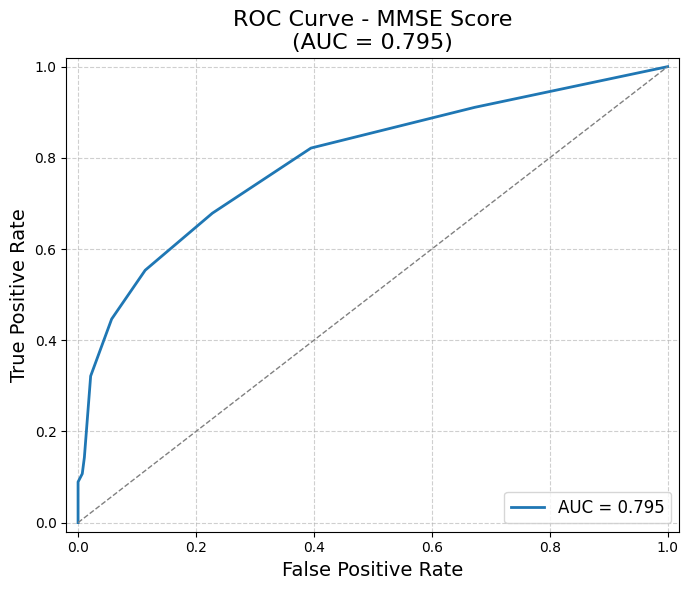

In [4]:
# Define features and target
X_train = df_train[['MMSCORE']]
y_train = df_train['AD']
X_test = df_test[['MMSCORE']]
y_test = df_test['AD']

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
sample_weights = y_train.map(dict(zip(np.unique(y_train), class_weights)))

# Run bootstrapped logistic regression
results = bootstrap_metrics(
    df_train=X_train,
    df_test=X_test,
    independent_vars=['MMSCORE'],
    dep_var_train=y_train,
    dep_var_test=y_test,
    n_bootstrap=1000,
    sample_weights=sample_weights  # Pass class weights
)

# Display results
print("\n===== Odds Ratios (one-time fit) — MMSE Score =====")
print(results["Odds Ratios (one-time fit)"])

print(f"\nBest Threshold Automatically Found: {results['Best Threshold']:.2f}")

print("\n===== Bootstrapped Metrics (1000 runs) - MMSE Score =====")
for metric, (mean, ci) in results["Bootstrapped Metrics"].items():
    print(f"{metric}: Mean = {mean:.4f}, 95% CI = [{ci[0]:.4f}, {ci[1]:.4f}]")

# (Optional) Plot ROC Curve
plot_roc_curve(results["True Labels"], results["Predicted Probabilities"], title="ROC Curve - MMSE Score")


## Logistic Regression on MMSE Questions with Bootstrapping

In [5]:
# Logistic Regression on MMSE Questions with Bootstrapping and Best Threshold Search

question_results = []
skipped_questions = []

for question in mmse_cols:
    try:
        # Define features and target
        X_train_question = df_train[[question]]
        y_train_question = df_train['AD']
        X_test_question = df_test[[question]]
        y_test_question = df_test['AD']

        # Run logistic regression with bootstrapping
        results_question = bootstrap_metrics(
            df_train=X_train_question,
            df_test=X_test_question,
            independent_vars=[question],
            dep_var_train=y_train_question,
            dep_var_test=y_test_question,
            n_bootstrap=1000
        )

        # Store results
        question_results.append({
            'Question': question,
            'Best Threshold': results_question['Best Threshold'],
            'Odds Ratios': results_question["Odds Ratios (one-time fit)"],
            'Bootstrapped Metrics': results_question["Bootstrapped Metrics"],
            'True Labels': results_question["True Labels"],
            'Predicted Probabilities': results_question["Predicted Probabilities"]
        })

    except Exception as e:
        print(f"Error running logistic regression for question {question}: {e}")
        skipped_questions.append({'Question': question, 'Error': str(e)})

# Display results for each question
for result in question_results:
    print(f"\n===== Odds Ratios (one-time fit) — {result['Question']} =====")
    print(result['Odds Ratios'])

    print(f"\nBest Threshold Automatically Found: {result['Best Threshold']:.2f}")

    print(f"\n===== Bootstrapped Metrics (1000 runs) - {result['Question']} =====")
    for metric, (mean, ci) in result['Bootstrapped Metrics'].items():
        print(f"{metric}: Mean = {mean:.4f}, 95% CI = [{ci[0]:.4f}, {ci[1]:.4f}]")

# Log skipped questions
if skipped_questions:
    print("\n===== Skipped Questions =====")
    for skipped in skipped_questions:
        print(f"Question: {skipped['Question']}, Error: {skipped['Error']}")

# # (Optional) Plot ROC Curve for each question
# for result in question_results:
#     plot_roc_curve(result["True Labels"], result["Predicted Probabilities"], title=f"ROC Curve - {result['Question']}")

Using class weighting automatically.
Best Threshold found automatically: 0.16


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method newton is: tol, ridge_factor. The list of unsupported keyword arguments passed include: weights. After release 0.14, this will raise.
  warnings.warn(


Using class weighting automatically.
Best Threshold found automatically: 0.15


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method newton is: tol, ridge_factor. The list of unsupported keyword arguments passed include: weights. After release 0.14, this will raise.
  warnings.warn(


Using class weighting automatically.
Best Threshold found automatically: 0.15


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method newton is: tol, ridge_factor. The list of unsupported keyword arguments passed include: weights. After release 0.14, this will raise.
  warnings.warn(


Using class weighting automatically.
Best Threshold found automatically: 0.15


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method newton is: tol, ridge_factor. The list of unsupported keyword arguments passed include: weights. After release 0.14, this will raise.
  warnings.warn(


Using class weighting automatically.
Best Threshold found automatically: 0.11


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method newton is: tol, ridge_factor. The list of unsupported keyword arguments passed include: weights. After release 0.14, this will raise.
  warnings.warn(


Using class weighting automatically.
Best Threshold found automatically: 0.17


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method newton is: tol, ridge_factor. The list of unsupported keyword arguments passed include: weights. After release 0.14, this will raise.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


Using class weighting automatically.
Best Threshold found automatically: 0.17


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method newton is: tol, ridge_factor. The list of unsupported keyword arguments passed include: weights. After release 0.14, this will raise.
  warnings.warn(


Using class weighting automatically.
Best Threshold found automatically: 0.16


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method newton is: tol, ridge_factor. The list of unsupported keyword arguments passed include: weights. After release 0.14, this will raise.
  warnings.warn(


Using class weighting automatically.
Best Threshold found automatically: 0.16


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method newton is: tol, ridge_factor. The list of unsupported keyword arguments passed include: weights. After release 0.14, this will raise.
  warnings.warn(


Using class weighting automatically.
Best Threshold found automatically: 0.14


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method newton is: tol, ridge_factor. The list of unsupported keyword arguments passed include: weights. After release 0.14, this will raise.
  warnings.warn(


Using class weighting automatically.
Error running logistic regression for question WORD1: Singular matrix
Using class weighting automatically.
Best Threshold found automatically: 0.10


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method newton is: tol, ridge_factor. The list of unsupported keyword arguments passed include: weights. After release 0.14, this will raise.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method newton is: tol, ridge_factor. The list of unsupported keyword arguments passed include: weights. After release 0.14, this will raise.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_ret

Using class weighting automatically.
Best Threshold found automatically: 0.10


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method newton is: tol, ridge_factor. The list of unsupported keyword arguments passed include: weights. After release 0.14, this will raise.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


Using class weighting automatically.
Best Threshold found automatically: 0.10


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method newton is: tol, ridge_factor. The list of unsupported keyword arguments passed include: weights. After release 0.14, this will raise.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


Using class weighting automatically.
Best Threshold found automatically: 0.10


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method newton is: tol, ridge_factor. The list of unsupported keyword arguments passed include: weights. After release 0.14, this will raise.
  warnings.warn(


Using class weighting automatically.
Best Threshold found automatically: 0.15


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method newton is: tol, ridge_factor. The list of unsupported keyword arguments passed include: weights. After release 0.14, this will raise.
  warnings.warn(


Using class weighting automatically.
Best Threshold found automatically: 0.15


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method newton is: tol, ridge_factor. The list of unsupported keyword arguments passed include: weights. After release 0.14, this will raise.
  warnings.warn(


Using class weighting automatically.
Best Threshold found automatically: 0.16


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method newton is: tol, ridge_factor. The list of unsupported keyword arguments passed include: weights. After release 0.14, this will raise.
  warnings.warn(


Using class weighting automatically.
Best Threshold found automatically: 0.10


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method newton is: tol, ridge_factor. The list of unsupported keyword arguments passed include: weights. After release 0.14, this will raise.
  warnings.warn(


Using class weighting automatically.
Best Threshold found automatically: 0.10


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method newton is: tol, ridge_factor. The list of unsupported keyword arguments passed include: weights. After release 0.14, this will raise.
  warnings.warn(


Using class weighting automatically.
Best Threshold found automatically: 0.10


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method newton is: tol, ridge_factor. The list of unsupported keyword arguments passed include: weights. After release 0.14, this will raise.
  warnings.warn(


Using class weighting automatically.
Best Threshold found automatically: 0.10


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method newton is: tol, ridge_factor. The list of unsupported keyword arguments passed include: weights. After release 0.14, this will raise.
  warnings.warn(


Using class weighting automatically.
Best Threshold found automatically: 0.10


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method newton is: tol, ridge_factor. The list of unsupported keyword arguments passed include: weights. After release 0.14, this will raise.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


Using class weighting automatically.
Best Threshold found automatically: 0.15


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method newton is: tol, ridge_factor. The list of unsupported keyword arguments passed include: weights. After release 0.14, this will raise.
  warnings.warn(


Using class weighting automatically.
Best Threshold found automatically: 0.17


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method newton is: tol, ridge_factor. The list of unsupported keyword arguments passed include: weights. After release 0.14, this will raise.
  warnings.warn(


Using class weighting automatically.
Best Threshold found automatically: 0.17


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method newton is: tol, ridge_factor. The list of unsupported keyword arguments passed include: weights. After release 0.14, this will raise.
  warnings.warn(


Using class weighting automatically.
Best Threshold found automatically: 0.17


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method newton is: tol, ridge_factor. The list of unsupported keyword arguments passed include: weights. After release 0.14, this will raise.
  warnings.warn(


Using class weighting automatically.
Best Threshold found automatically: 0.17


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method newton is: tol, ridge_factor. The list of unsupported keyword arguments passed include: weights. After release 0.14, this will raise.
  warnings.warn(


Using class weighting automatically.
Best Threshold found automatically: 0.17


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method newton is: tol, ridge_factor. The list of unsupported keyword arguments passed include: weights. After release 0.14, this will raise.
  warnings.warn(


Using class weighting automatically.
Best Threshold found automatically: 0.16


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method newton is: tol, ridge_factor. The list of unsupported keyword arguments passed include: weights. After release 0.14, this will raise.
  warnings.warn(



===== Odds Ratios (one-time fit) — MMYEAR =====
        Odds Ratio  95% CI Lower  95% CI Upper       p-value
const     3.600000      1.336592      9.696303  1.128111e-02
MMYEAR    0.049663      0.018088      0.136354  5.658192e-09

Best Threshold Automatically Found: 0.16

===== Bootstrapped Metrics (1000 runs) - MMYEAR =====
AUC: Mean = 0.5125, 95% CI = [0.5037, 0.5146]
Balanced Accuracy: Mean = 0.5125, 95% CI = [0.5037, 0.5146]
Sensitivity: Mean = 0.0357, 95% CI = [0.0182, 0.0364]
Specificity: Mean = 0.9893, 95% CI = [0.9892, 0.9928]
F1-score: Mean = 0.0655, 95% CI = [0.0339, 0.0678]

===== Odds Ratios (one-time fit) — MMMONTH =====
         Odds Ratio  95% CI Lower  95% CI Upper       p-value
const      3.000000      1.275341      7.056934  1.182792e-02
MMMONTH    0.058257      0.024212      0.140177  2.210977e-10

Best Threshold Automatically Found: 0.15

===== Bootstrapped Metrics (1000 runs) - MMMONTH =====
AUC: Mean = 0.5501, 95% CI = [0.5419, 0.5528]
Balanced Accuracy: Mean = 

## Logistic Regression on MMSE Category with Bootstrapping


Running logistic regression for category: Orientation_Time
Using class weighting automatically.
Best Threshold found automatically: 0.10


/var/folders/1n/916yypk515j1_yw9pbqh_rmw0000gn/T/ipykernel_47551/4198454259.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train[f"{category}_COMPOSITE"] = df_train[questions].sum(axis=1, skipna=True)
/var/folders/1n/916yypk515j1_yw9pbqh_rmw0000gn/T/ipykernel_47551/4198454259.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[f"{category}_COMPOSITE"] = df_test[questions].sum(axis=1, skipna=True)
/var/folders/1n/916yypk515j1_yw9pbqh_rmw0000gn/T/ipykernel_47551/4198454259.py:3: SettingWithCop


Running logistic regression for category: Orientation_Place
Using class weighting automatically.
Best Threshold found automatically: 0.13


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method newton is: tol, ridge_factor. The list of unsupported keyword arguments passed include: weights. After release 0.14, this will raise.
  warnings.warn(



Running logistic regression for category: Registration
Using class weighting automatically.
Best Threshold found automatically: 0.10


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method newton is: tol, ridge_factor. The list of unsupported keyword arguments passed include: weights. After release 0.14, this will raise.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)



Running logistic regression for category: Attention_Calculation
Using class weighting automatically.
Best Threshold found automatically: 0.39


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method newton is: tol, ridge_factor. The list of unsupported keyword arguments passed include: weights. After release 0.14, this will raise.
  warnings.warn(



Running logistic regression for category: Recall
Using class weighting automatically.
Best Threshold found automatically: 0.15


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method newton is: tol, ridge_factor. The list of unsupported keyword arguments passed include: weights. After release 0.14, this will raise.
  warnings.warn(



Running logistic regression for category: Language
Using class weighting automatically.
Best Threshold found automatically: 0.13


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method newton is: tol, ridge_factor. The list of unsupported keyword arguments passed include: weights. After release 0.14, this will raise.
  warnings.warn(



============ Results for Orientation_Time ============
----- Odds Ratios (one-time fit) -----
                            Odds Ratio  95% CI Lower  95% CI Upper  \
const                        99.405512     30.134791    327.908557   
Orientation_Time_COMPOSITE    0.248469      0.190197      0.324594   

                                 p-value  
const                       4.265233e-14  
Orientation_Time_COMPOSITE  1.760204e-24  

Best Threshold Automatically Found: 0.10

----- Bootstrapped Metrics (1000 runs) -----
AUC: Mean = 0.6507, 95% CI = [0.6432, 0.6575]
Balanced Accuracy: Mean = 0.6343, 95% CI = [0.6281, 0.6408]
Sensitivity: Mean = 0.4822, 95% CI = [0.4727, 0.4909]
Specificity: Mean = 0.7865, 95% CI = [0.7834, 0.7942]
F1-score: Mean = 0.3770, 95% CI = [0.3688, 0.3857]

============ Results for Orientation_Place ============
----- Odds Ratios (one-time fit) -----
                             Odds Ratio  95% CI Lower  95% CI Upper  \
const                        150.202778     2

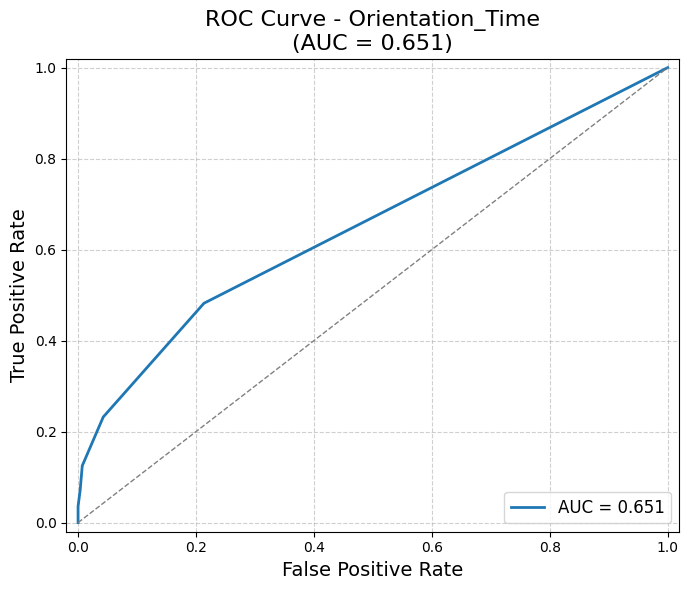

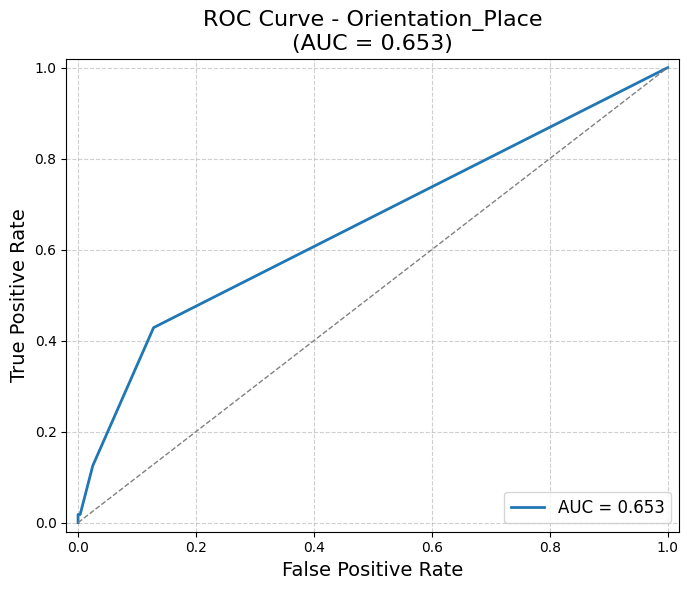

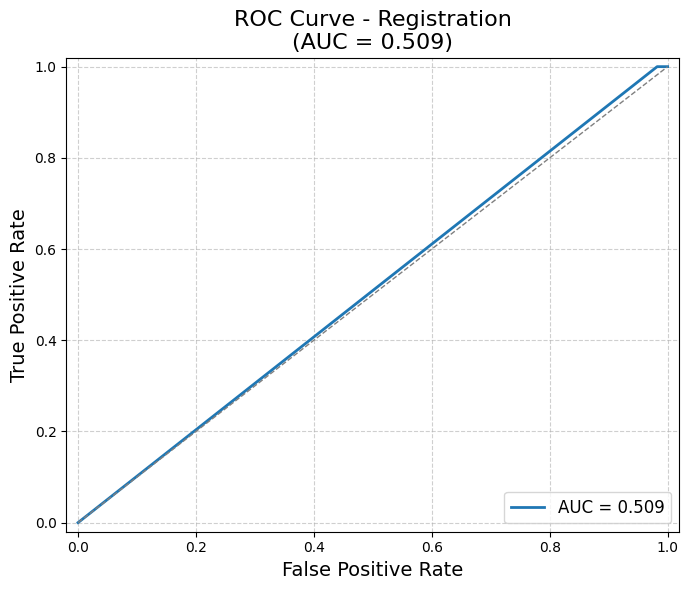

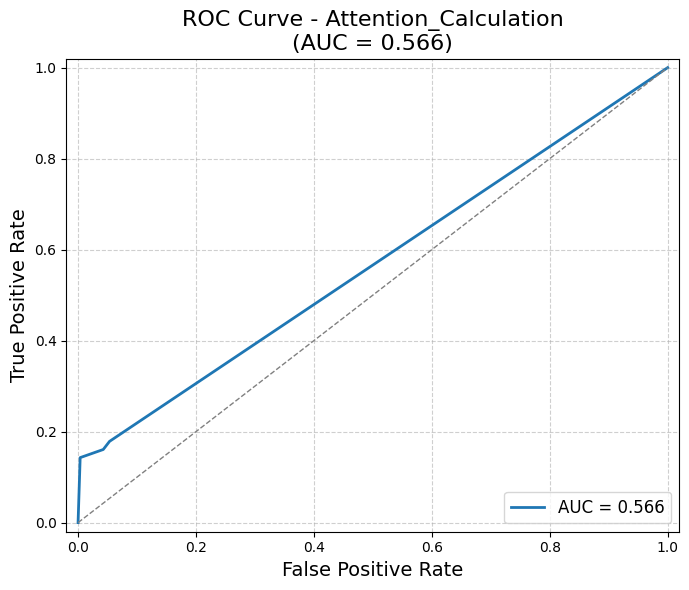

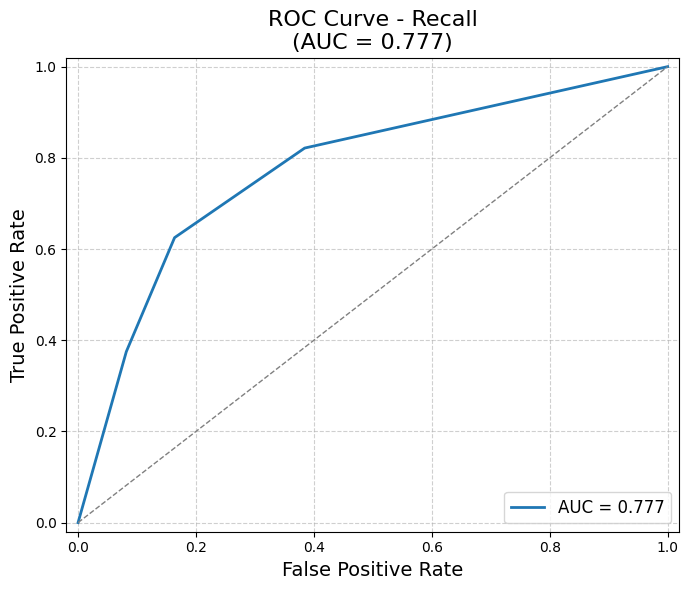

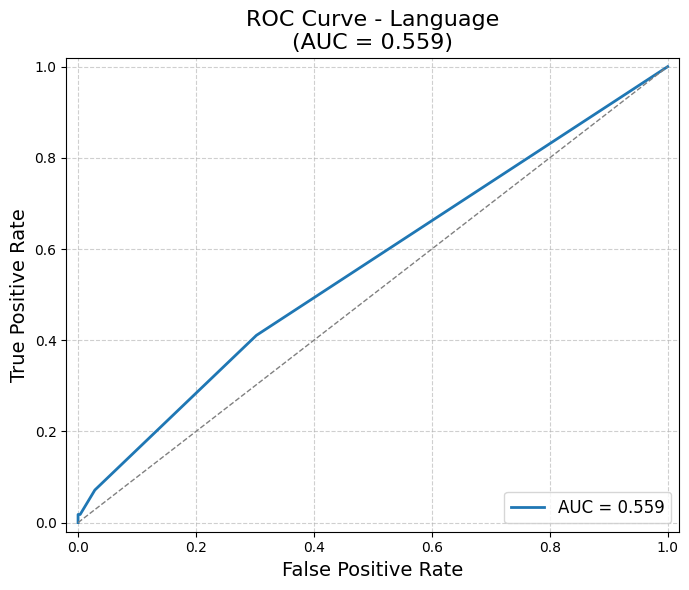


✅ Significant categories selected: ['Orientation_Time_COMPOSITE', 'Orientation_Place_COMPOSITE', 'Attention_Calculation_COMPOSITE', 'Recall_COMPOSITE', 'Language_COMPOSITE']

🔎 Correlation matrix between significant categories:
                                  Orientation_Time_COMPOSITE  \
Orientation_Time_COMPOSITE                         1.000000   
Orientation_Place_COMPOSITE                        0.357870   
Attention_Calculation_COMPOSITE                    0.174630   
Recall_COMPOSITE                                   0.415778   
Language_COMPOSITE                                 0.135798   

                                 Orientation_Place_COMPOSITE  \
Orientation_Time_COMPOSITE                          0.357870   
Orientation_Place_COMPOSITE                         1.000000   
Attention_Calculation_COMPOSITE                     0.147989   
Recall_COMPOSITE                                    0.293434   
Language_COMPOSITE                                  0.158549   

      

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method newton is: tol, ridge_factor. The list of unsupported keyword arguments passed include: weights. After release 0.14, this will raise.
  warnings.warn(



============ Results for Significant Combined Model ============
----- Odds Ratios (one-time fit) -----
                                    Odds Ratio  95% CI Lower  95% CI Upper  \
const                            484939.074968   7691.066865  3.057650e+07   
Orientation_Time_COMPOSITE            0.366278      0.273737  4.901033e-01   
Orientation_Place_COMPOSITE           0.461352      0.295355  7.206420e-01   
Attention_Calculation_COMPOSITE       0.647267      0.482081  8.690557e-01   
Recall_COMPOSITE                      0.527801      0.432650  6.438787e-01   
Language_COMPOSITE                    0.679824      0.470374  9.825391e-01   

                                      p-value  
const                            5.940638e-10  
Orientation_Time_COMPOSITE       1.385024e-11  
Orientation_Place_COMPOSITE      6.745266e-04  
Attention_Calculation_COMPOSITE  3.809228e-03  
Recall_COMPOSITE                 2.966219e-10  
Language_COMPOSITE               4.000435e-02  

Best Thresh

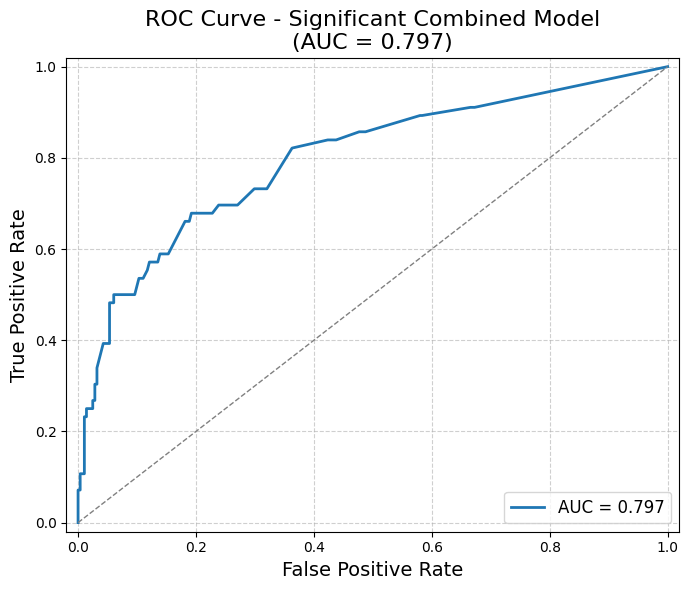

In [6]:
# Create composite scores for each category
for category, questions in categories.items():
    df_train[f"{category}_COMPOSITE"] = df_train[questions].sum(axis=1, skipna=True)
    df_test[f"{category}_COMPOSITE"] = df_test[questions].sum(axis=1, skipna=True)

# Analyze each category
category_results = []

for category in categories.keys():
    print(f"\nRunning logistic regression for category: {category}")

    try:
        # Define features and target
        X_train_category = df_train[[f"{category}_COMPOSITE"]]
        y_train_category = df_train['AD']
        X_test_category = df_test[[f"{category}_COMPOSITE"]]
        y_test_category = df_test['AD']

        # Run logistic regression with bootstrapping (auto threshold)
        results_category = bootstrap_metrics(
            df_train=X_train_category,
            df_test=X_test_category,
            independent_vars=[f"{category}_COMPOSITE"],
            dep_var_train=y_train_category,
            dep_var_test=y_test_category,
            n_bootstrap=1000
        )

        # Save results
        category_results.append({
            'Category': category,
            'Best Threshold': results_category["Best Threshold"],
            'Odds Ratios': results_category["Odds Ratios (one-time fit)"],
            'Bootstrapped Metrics': results_category["Bootstrapped Metrics"],
            'True Labels': results_category["True Labels"],
            'Predicted Probabilities': results_category["Predicted Probabilities"]
        })

    except Exception as e:
        print(f"Error running logistic regression for category {category}: {e}")
        continue

# Display results for each category
for result in category_results:
    print(f"\n============ Results for {result['Category']} ============")
    print("----- Odds Ratios (one-time fit) -----")
    print(result['Odds Ratios'])
    print(f"\nBest Threshold Automatically Found: {result['Best Threshold']:.2f}")
    print("\n----- Bootstrapped Metrics (1000 runs) -----")
    for metric, (mean, ci) in result['Bootstrapped Metrics'].items():
        print(f"{metric}: Mean = {mean:.4f}, 95% CI = [{ci[0]:.4f}, {ci[1]:.4f}]")

# (Optional) Plot ROC Curve for each category
for result in category_results:
    plot_roc_curve(result["True Labels"], result["Predicted Probabilities"], title=f"ROC Curve - {result['Category']}")

# ======= Logistic Regression on Combined Model =======

# 1. Analyze per-category results
significant_categories = []

for result in category_results:
    try:
        odds_ratios = result['Odds Ratios']
        
        # We check the p-value of the composite variable (not 'const')
        p_values = odds_ratios.loc[~odds_ratios.index.str.contains('const'), 'p-value']
        
        if (p_values < 0.05).all():  # If ALL features are significant
            significant_categories.append(f"{result['Category']}_COMPOSITE")
            
    except Exception as e:
        print(f"Error checking significance for {result['Category']}: {e}")
        continue

print(f"\n✅ Significant categories selected: {significant_categories}")

# 2. Prepare train and test data for combined model
X_train_significant = df_train[significant_categories]
X_test_significant = df_test[significant_categories]
y_train_significant = df_train['AD']
y_test_significant = df_test['AD']

# 3. (Optional) Check correlations
corr_matrix = X_train_significant.corr()
print("\n🔎 Correlation matrix between significant categories:\n", corr_matrix)

# (Optional) Remove highly correlated composites (>0.90)
features_to_drop = drop_highly_correlated_features(X_train_significant, threshold=0.90)

# Drop them
X_train_final = X_train_significant.drop(columns=features_to_drop)
X_test_final = X_test_significant.drop(columns=features_to_drop)
print(f"\nDropped features due to high correlation: {features_to_drop}")

# 4. Run logistic regression on significant combined model
results_clean_combined = bootstrap_metrics(
    df_train=X_train_final,
    df_test=X_test_final,
    independent_vars=X_train_final.columns.tolist(),
    dep_var_train=y_train_significant,
    dep_var_test=y_test_significant,
    n_bootstrap=1000
)

# 5. Display new combined model
print("\n============ Results for Significant Combined Model ============")
print("----- Odds Ratios (one-time fit) -----")
print(results_clean_combined["Odds Ratios (one-time fit)"])

print(f"\nBest Threshold Automatically Found: {results_clean_combined['Best Threshold']:.2f}")

print("\n----- Bootstrapped Metrics (1000 runs) -----")
for metric, (mean, ci) in results_clean_combined["Bootstrapped Metrics"].items():
    print(f"{metric}: Mean = {mean:.4f}, 95% CI = [{ci[0]:.4f}, {ci[1]:.4f}]")

# 7. Plot ROC Curve
plot_roc_curve(results_clean_combined["True Labels"], results_clean_combined["Predicted Probabilities"], title="ROC Curve - Significant Combined Model"
)

## Logistic regression on ClinicalBERT embeddings.


Running logistic regression for ClinicalBERT - Category: Orientation_Time
Using class weighting automatically.


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method newton is: tol, ridge_factor. The list of unsupported keyword arguments passed include: weights. After release 0.14, this will raise.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


Best Threshold found automatically: 0.16

Running logistic regression for ClinicalBERT - Category: Orientation_Place
Using class weighting automatically.


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method newton is: tol, ridge_factor. The list of unsupported keyword arguments passed include: weights. After release 0.14, this will raise.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


Best Threshold found automatically: 0.17

Running logistic regression for ClinicalBERT - Category: Attention_Calculation
Using class weighting automatically.


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method newton is: tol, ridge_factor. The list of unsupported keyword arguments passed include: weights. After release 0.14, this will raise.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


Best Threshold found automatically: 0.16

Running logistic regression for ClinicalBERT - Category: Recall
Using class weighting automatically.


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method newton is: tol, ridge_factor. The list of unsupported keyword arguments passed include: weights. After release 0.14, this will raise.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


Best Threshold found automatically: 0.10

Running logistic regression for ClinicalBERT - Category: Language
Using class weighting automatically.


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method newton is: tol, ridge_factor. The list of unsupported keyword arguments passed include: weights. After release 0.14, this will raise.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


Best Threshold found automatically: 0.10

Running combined logistic regression for ClinicalBERT (mean embeddings per category)
Using class weighting automatically.
Best Threshold found automatically: 0.12


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method newton is: tol, ridge_factor. The list of unsupported keyword arguments passed include: weights. After release 0.14, this will raise.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)



=== Results for ClinicalBERT - Category: Orientation_Time ===

----- Odds Ratios (one-time fit) -----
               Odds Ratio  95% CI Lower  95% CI Upper  p-value
const            1.008800           NaN           NaN      NaN
Embedding_0      0.987648           NaN           NaN      NaN
Embedding_1      1.038392           NaN           NaN      NaN
Embedding_2      1.033304           0.0           inf      1.0
Embedding_3      0.967367           NaN           NaN      NaN
...                   ...           ...           ...      ...
Embedding_763    1.140972           0.0           inf      1.0
Embedding_764    1.080493           NaN           NaN      NaN
Embedding_765    1.049804           0.0           inf      1.0
Embedding_766    0.890663           NaN           NaN      NaN
Embedding_767    1.152635           0.0           inf      1.0

[769 rows x 4 columns]

Best Threshold Automatically Found: 0.16

----- Bootstrapped Metrics (1000 runs) -----
AUC: Mean = 0.5927, 95% CI = 

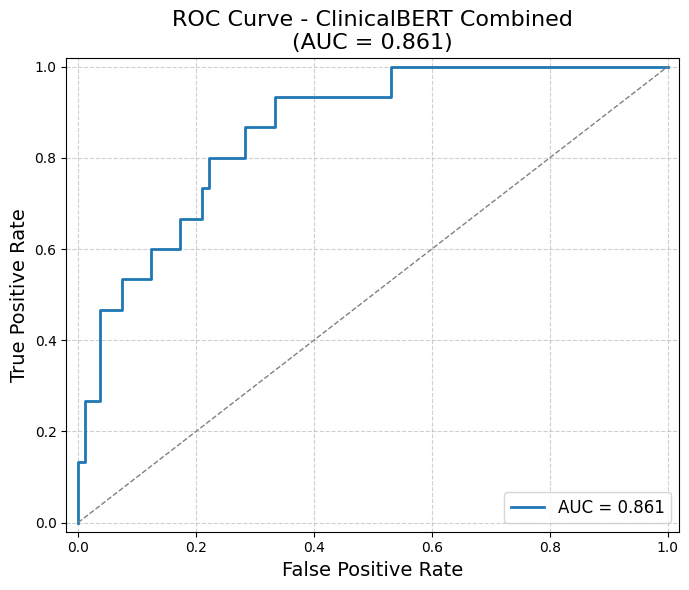

In [7]:
clinicalbert_category_results, clinicalbert_combined_result = run_logistic_regression_pipeline(
    train_df=df_clincalbert_train,
    test_df=df_clincalbert_test,
    embedding_cols=[col for col in df_clincalbert_train.columns if col.startswith('Embedding_')],
    categories=updated_categories,
    model_name="ClinicalBERT"
)


## Logistic Regression on Contextual ClinicalBERT embeddings


Running logistic regression for Contextual ClinicalBERT - Category: Orientation_Time
Using class weighting automatically.


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method newton is: tol, ridge_factor. The list of unsupported keyword arguments passed include: weights. After release 0.14, this will raise.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


Best Threshold found automatically: 0.17

Running logistic regression for Contextual ClinicalBERT - Category: Orientation_Place
Using class weighting automatically.


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method newton is: tol, ridge_factor. The list of unsupported keyword arguments passed include: weights. After release 0.14, this will raise.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


Best Threshold found automatically: 0.17

Running logistic regression for Contextual ClinicalBERT - Category: Attention_Calculation
Using class weighting automatically.


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method newton is: tol, ridge_factor. The list of unsupported keyword arguments passed include: weights. After release 0.14, this will raise.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


Best Threshold found automatically: 0.16

Running logistic regression for Contextual ClinicalBERT - Category: Recall
Using class weighting automatically.


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method newton is: tol, ridge_factor. The list of unsupported keyword arguments passed include: weights. After release 0.14, this will raise.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


Best Threshold found automatically: 0.11

Running logistic regression for Contextual ClinicalBERT - Category: Language
Using class weighting automatically.


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method newton is: tol, ridge_factor. The list of unsupported keyword arguments passed include: weights. After release 0.14, this will raise.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


Best Threshold found automatically: 0.17

Running combined logistic regression for Contextual ClinicalBERT (mean embeddings per category)
Using class weighting automatically.
Best Threshold found automatically: 0.18


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method newton is: tol, ridge_factor. The list of unsupported keyword arguments passed include: weights. After release 0.14, this will raise.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)



=== Results for Contextual ClinicalBERT - Category: Orientation_Time ===

----- Odds Ratios (one-time fit) -----
                       Odds Ratio  95% CI Lower  95% CI Upper  p-value
const                    0.983291           NaN           NaN      NaN
Context_Embedding_0      0.979138           0.0           inf      1.0
Context_Embedding_1      1.151089           0.0           inf      1.0
Context_Embedding_2      1.076303           NaN           NaN      NaN
Context_Embedding_3      1.129488           NaN           NaN      NaN
...                           ...           ...           ...      ...
Context_Embedding_763    0.936879           NaN           NaN      NaN
Context_Embedding_764    0.975608           0.0           inf      1.0
Context_Embedding_765    1.008623           NaN           NaN      NaN
Context_Embedding_766    1.141938           NaN           NaN      NaN
Context_Embedding_767    1.218563           NaN           NaN      NaN

[769 rows x 4 columns]

Best Thre

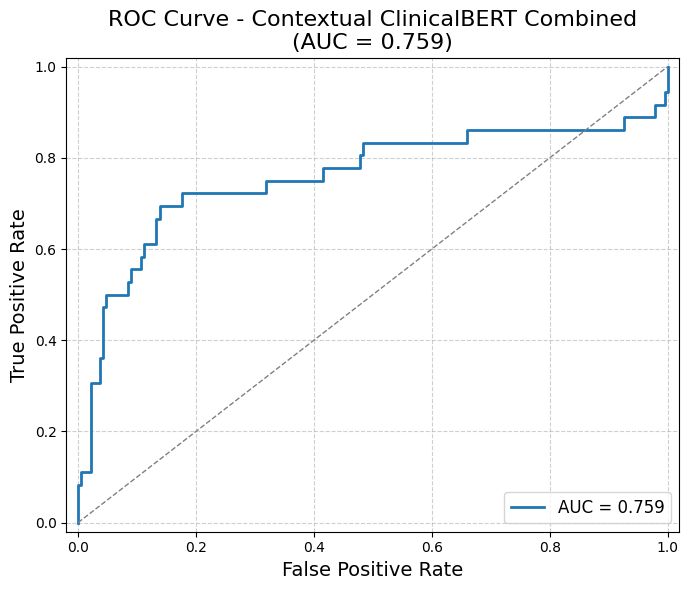

In [8]:
context_clinicalbert_category_results, context_clinicalbert_combined_result = run_logistic_regression_pipeline(
    train_df=df_context_clinicalbert_train,
    test_df=df_context_clinicalbert_test,
    embedding_cols=[col for col in df_context_clinicalbert_train.columns if col.startswith('Context_Embedding_')],
    categories=updated_categories,
    model_name="Contextual ClinicalBERT"
)


## Logistic Regression on BioBert embeddings


Running logistic regression for BioBERT - Category: Orientation_Time
Using class weighting automatically.


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method newton is: tol, ridge_factor. The list of unsupported keyword arguments passed include: weights. After release 0.14, this will raise.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


Best Threshold found automatically: 0.16

Running logistic regression for BioBERT - Category: Orientation_Place
Using class weighting automatically.


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method newton is: tol, ridge_factor. The list of unsupported keyword arguments passed include: weights. After release 0.14, this will raise.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


Best Threshold found automatically: 0.17

Running logistic regression for BioBERT - Category: Attention_Calculation
Using class weighting automatically.


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method newton is: tol, ridge_factor. The list of unsupported keyword arguments passed include: weights. After release 0.14, this will raise.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


Best Threshold found automatically: 0.16

Running logistic regression for BioBERT - Category: Recall
Using class weighting automatically.


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method newton is: tol, ridge_factor. The list of unsupported keyword arguments passed include: weights. After release 0.14, this will raise.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


Best Threshold found automatically: 0.10

Running logistic regression for BioBERT - Category: Language
Using class weighting automatically.


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method newton is: tol, ridge_factor. The list of unsupported keyword arguments passed include: weights. After release 0.14, this will raise.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


Best Threshold found automatically: 0.10

Running combined logistic regression for BioBERT (mean embeddings per category)
Using class weighting automatically.
Best Threshold found automatically: 0.52


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method newton is: tol, ridge_factor. The list of unsupported keyword arguments passed include: weights. After release 0.14, this will raise.
  warnings.warn(



=== Results for BioBERT - Category: Orientation_Time ===

----- Odds Ratios (one-time fit) -----
               Odds Ratio  95% CI Lower  95% CI Upper   p-value
const            1.023766           NaN           NaN       NaN
Embedding_0      0.853653           NaN           NaN       NaN
Embedding_1      1.099378           0.0           inf  1.000000
Embedding_2      0.955126           NaN           NaN       NaN
Embedding_3      1.068639           0.0           inf  1.000000
...                   ...           ...           ...       ...
Embedding_763    0.827456           NaN           NaN       NaN
Embedding_764    0.963124           NaN           NaN       NaN
Embedding_765    0.913359           0.0           inf  1.000000
Embedding_766    0.783462           0.0           inf  0.999999
Embedding_767    1.256234           0.0           inf  1.000000

[769 rows x 4 columns]

Best Threshold Automatically Found: 0.16

----- Bootstrapped Metrics (1000 runs) -----
AUC: Mean = 0.5927, 95

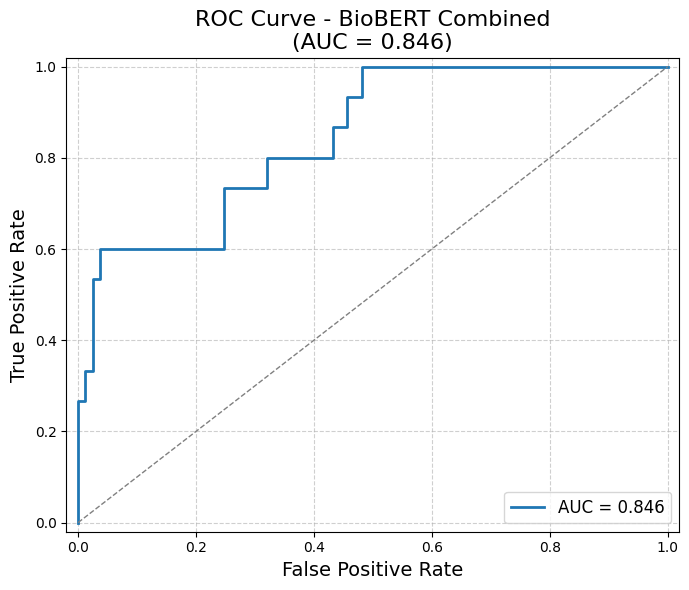

In [9]:
biobert_category_results, bio_combined_result = run_logistic_regression_pipeline(
    train_df=df_biobert_train,
    test_df=df_biobert_test,
    embedding_cols=[col for col in df_biobert_train.columns if col.startswith('Embedding_')],
    categories=updated_categories,
    model_name="BioBERT"
)

## Logistic Regression on Contextual BioBert embeddings

In [13]:
context_biobert_category_results, context_biobert_combined_result = run_logistic_regression_pipeline(
    train_df=df_context_biobert_train,
    test_df=df_context_biobert_test,
    embedding_cols=[col for col in df_context_biobert_train.columns if col.startswith('Context_Embedding_')],
    categories=updated_categories,
    model_name="Contextual BioBERT"
)


Running logistic regression for Contextual BioBERT - Category: Orientation_Time
Using class weighting automatically.


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method newton is: tol, ridge_factor. The list of unsupported keyword arguments passed include: weights. After release 0.14, this will raise.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


Best Threshold found automatically: 0.17

Running logistic regression for Contextual BioBERT - Category: Orientation_Place
Using class weighting automatically.


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method newton is: tol, ridge_factor. The list of unsupported keyword arguments passed include: weights. After release 0.14, this will raise.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


Best Threshold found automatically: 0.17

Running logistic regression for Contextual BioBERT - Category: Attention_Calculation
Using class weighting automatically.


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method newton is: tol, ridge_factor. The list of unsupported keyword arguments passed include: weights. After release 0.14, this will raise.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


Best Threshold found automatically: 0.16

Running logistic regression for Contextual BioBERT - Category: Recall
Using class weighting automatically.


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method newton is: tol, ridge_factor. The list of unsupported keyword arguments passed include: weights. After release 0.14, this will raise.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


Best Threshold found automatically: 0.11

Running logistic regression for Contextual BioBERT - Category: Language
Using class weighting automatically.


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method newton is: tol, ridge_factor. The list of unsupported keyword arguments passed include: weights. After release 0.14, this will raise.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


Best Threshold found automatically: 0.10

Running combined logistic regression for Contextual BioBERT (mean embeddings per category)
Using class weighting automatically.


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method newton is: tol, ridge_factor. The list of unsupported keyword arguments passed include: weights. After release 0.14, this will raise.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/discrete/discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/discrete/discrete_model.py:2443: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


LinAlgError: Singular matrix

## Logistic Regression on MedBERT embeddings


Running logistic regression for MedBERT - Category: Orientation_Time
Using class weighting automatically.


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method newton is: tol, ridge_factor. The list of unsupported keyword arguments passed include: weights. After release 0.14, this will raise.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


Best Threshold found automatically: 0.16

Running logistic regression for MedBERT - Category: Orientation_Place
Using class weighting automatically.


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method newton is: tol, ridge_factor. The list of unsupported keyword arguments passed include: weights. After release 0.14, this will raise.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


Best Threshold found automatically: 0.17

Running logistic regression for MedBERT - Category: Attention_Calculation
Using class weighting automatically.


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method newton is: tol, ridge_factor. The list of unsupported keyword arguments passed include: weights. After release 0.14, this will raise.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


Best Threshold found automatically: 0.16

Running logistic regression for MedBERT - Category: Recall
Using class weighting automatically.


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method newton is: tol, ridge_factor. The list of unsupported keyword arguments passed include: weights. After release 0.14, this will raise.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


Best Threshold found automatically: 0.10

Running logistic regression for MedBERT - Category: Language
Using class weighting automatically.


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method newton is: tol, ridge_factor. The list of unsupported keyword arguments passed include: weights. After release 0.14, this will raise.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


Best Threshold found automatically: 0.10

Running combined logistic regression for MedBERT (mean embeddings per category)
Using class weighting automatically.
Best Threshold found automatically: 0.10


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method newton is: tol, ridge_factor. The list of unsupported keyword arguments passed include: weights. After release 0.14, this will raise.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/discrete/discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/discrete/discrete_model.py:2443: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge


=== Results for MedBERT - Category: Orientation_Time ===

----- Odds Ratios (one-time fit) -----
               Odds Ratio  95% CI Lower  95% CI Upper  p-value
const            1.001572           0.0           inf      1.0
Embedding_0      1.020876           NaN           NaN      NaN
Embedding_1      0.981474           0.0           inf      1.0
Embedding_2      1.010125           0.0           inf      1.0
Embedding_3      0.996039           NaN           NaN      NaN
...                   ...           ...           ...      ...
Embedding_763    0.999673           NaN           NaN      NaN
Embedding_764    0.989112           NaN           NaN      NaN
Embedding_765    0.994933           0.0           inf      1.0
Embedding_766    0.993302           0.0           inf      1.0
Embedding_767    0.994176           0.0           inf      1.0

[769 rows x 4 columns]

Best Threshold Automatically Found: 0.16

----- Bootstrapped Metrics (1000 runs) -----
AUC: Mean = 0.5927, 95% CI = [0.59

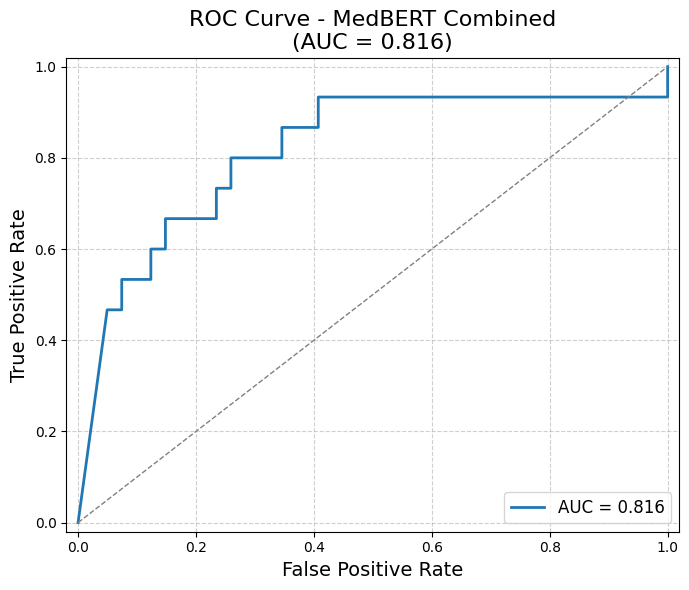

In [11]:
medbert_category_results, medbert_combined_result = run_logistic_regression_pipeline(
    train_df=df_medbert_train,
    test_df=df_medbert_test,
    embedding_cols=[col for col in df_medbert_train.columns if col.startswith('Embedding_')],
    categories=updated_categories,
    model_name="MedBERT"
)

## Logisitc Regression on Contextual MedBERT embeddings


Running logistic regression for Contextual MedBERT - Category: Orientation_Time
Using class weighting automatically.


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method newton is: tol, ridge_factor. The list of unsupported keyword arguments passed include: weights. After release 0.14, this will raise.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


Best Threshold found automatically: 0.17

Running logistic regression for Contextual MedBERT - Category: Orientation_Place
Using class weighting automatically.


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method newton is: tol, ridge_factor. The list of unsupported keyword arguments passed include: weights. After release 0.14, this will raise.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


Best Threshold found automatically: 0.17

Running logistic regression for Contextual MedBERT - Category: Attention_Calculation
Using class weighting automatically.


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method newton is: tol, ridge_factor. The list of unsupported keyword arguments passed include: weights. After release 0.14, this will raise.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


Best Threshold found automatically: 0.16

Running logistic regression for Contextual MedBERT - Category: Recall
Using class weighting automatically.


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method newton is: tol, ridge_factor. The list of unsupported keyword arguments passed include: weights. After release 0.14, this will raise.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


Best Threshold found automatically: 0.11

Running logistic regression for Contextual MedBERT - Category: Language
Using class weighting automatically.


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method newton is: tol, ridge_factor. The list of unsupported keyword arguments passed include: weights. After release 0.14, this will raise.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


Best Threshold found automatically: 0.10

Running combined logistic regression for Contextual MedBERT (mean embeddings per category)
Using class weighting automatically.
Best Threshold found automatically: 0.32


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method newton is: tol, ridge_factor. The list of unsupported keyword arguments passed include: weights. After release 0.14, this will raise.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)



=== Results for Contextual MedBERT - Category: Orientation_Time ===

----- Odds Ratios (one-time fit) -----
                       Odds Ratio  95% CI Lower  95% CI Upper  p-value
const                    1.001264           NaN           NaN      NaN
Context_Embedding_0      0.988558           0.0           inf      1.0
Context_Embedding_1      1.043411           NaN           NaN      NaN
Context_Embedding_2      0.989211           NaN           NaN      NaN
Context_Embedding_3      0.976049           NaN           NaN      NaN
...                           ...           ...           ...      ...
Context_Embedding_763    1.001592           0.0           inf      1.0
Context_Embedding_764    0.989855           0.0           inf      1.0
Context_Embedding_765    0.986146           0.0           inf      1.0
Context_Embedding_766    0.988785           0.0           inf      1.0
Context_Embedding_767    0.977573           NaN           NaN      NaN

[769 rows x 4 columns]

Best Threshold

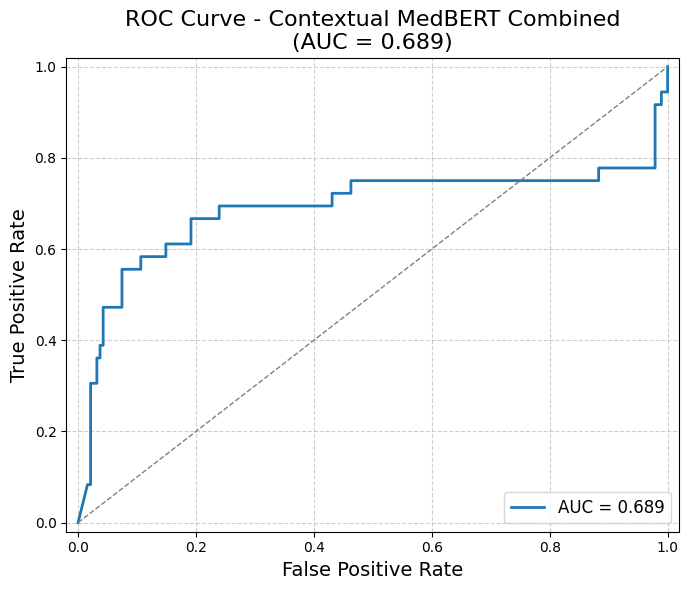

In [12]:
context_medbert_category_results, context_medbert_combined_result = run_logistic_regression_pipeline(
    train_df=df_context_medbert_train,
    test_df=df_context_medbert_test,
    embedding_cols=[col for col in df_context_medbert_train.columns if col.startswith('Context_Embedding_')],
    categories=updated_categories,
    model_name="Contextual MedBERT"
)